In [1]:
#https://www.kaggle.com/mrwellsdavid/unsw-nb15?select=UNSW_NB15_testing-set.csv -датасет

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')#чтобы не светились всякие предупреждения
pd.set_option('display.max_columns', 999)#чтоб датасет был виден целиком
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import homogeneity_score

from itertools import cycle, islice
plt.rcParams['figure.figsize'] = 12, 8#чтоб графики были большими и наглядными
import numpy as np
np.random.seed(0)#фиксируем инициализацию рандома чтобы у нас совпадали эксперименты
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

In [3]:
data=pd.read_csv('UNSW_NB15_testing-set.csv')
data.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,252,1572.271851,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,252,2740.178955,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,252,8561.499023,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,Normal,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 175341 non-null  int64  
 1   dur                175341 non-null  float64
 2   proto              175341 non-null  object 
 3   service            175341 non-null  object 
 4   state              175341 non-null  object 
 5   spkts              175341 non-null  int64  
 6   dpkts              175341 non-null  int64  
 7   sbytes             175341 non-null  int64  
 8   dbytes             175341 non-null  int64  
 9   rate               175341 non-null  float64
 10  sttl               175341 non-null  int64  
 11  dttl               175341 non-null  int64  
 12  sload              175341 non-null  float64
 13  dload              175341 non-null  float64
 14  sloss              175341 non-null  int64  
 15  dloss              175341 non-null  int64  
 16  si

In [5]:
cat_params=['proto','service','state','attack_cat']
num_params=['dur','spkts','dpkts','sbytes','dbytes','rate','sttl','dttl','sload','dload','sinpkt','dinpkt','sjit','djit',
            'swin','stcpb','dtcpb','dwin','tcprtt','synack','ackdat','smean','dmean','trans_depth','response_body_len',
            'ct_srv_src','ct_srv_src','ct_state_ttl','ct_dst_ltm','ct_src_dport_ltm','ct_dst_sport_ltm','ct_dst_src_ltm',
            'is_ftp_login','ct_ftp_cmd','ct_flw_http_mthd','ct_src_ltm','ct_srv_dst','is_sm_ips_ports']

# EDA

In [9]:
#наша вспомогательная функция которая сразу вычисляет все описательные статистические характеристики параметра
#такие как мин,макс,значения и строит график распределения
#
def num_describer(df,param,bins=20):
    print('Описание параметра ',param)
    nulls=round(df[param].isnull().sum()/len(df[param]),4)
    low = df[param].min()
    median = df[param].median()
    mean = df[param].mean()
    hight = df[param].max()
    IQR = df[param].quantile(
        0.75) - df[param].quantile(0.25)
    perc25 = df[param].quantile(0.25)
    perc75 = df[param].quantile(0.75)

    print('доля пропусков : {} \n\r'.format(nulls),
          'min : {} \n\r'.format(low),
          '25-й перцентиль: {} \n\r'.format(perc25),
          'медиана: {} \n\r'.format(median),
          'среднее: {} \n\r'.format(mean),
          'max : {} \n\r'.format(hight),
          '75-й перцентиль: {} \n\r'.format(perc75),
          "IQR: {} \n\r".format(IQR),
          "Границы выбросов: [{f}, {l}] \n\r".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR),
         )
    fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2,
    figsize=(8, 4))
    sns.distplot(df[param],ax=ax1)
    str1='Распределение значений '+param
    ax1.set_title(str1)
    ax1.legend()
    sns.distplot(np.log(df[param]+1),ax=ax2)
    str2='Логорифмированное Распределение значений '+param
    ax2.set_title(str2)
    ax2.legend()
    plt.show()

Описание параметра  dur
доля пропусков : 0.0 
 min : 0.0 
 25-й перцентиль: 8e-06 
 медиана: 0.001582 
 среднее: 1.3593886921261156 
 max : 59.999989 
 75-й перцентиль: 0.6680689999999999 
 IQR: 0.6680609999999999 
 Границы выбросов: [-1.0020835, 1.6701604999999997] 



No handles with labels found to put in legend.
No handles with labels found to put in legend.


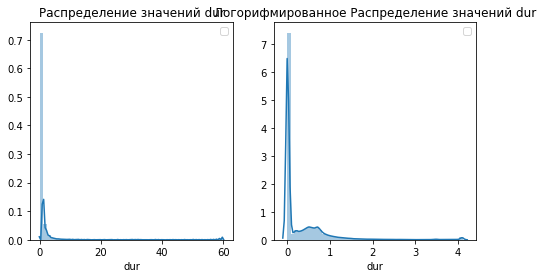

No handles with labels found to put in legend.


Описание параметра  spkts
доля пропусков : 0.0 
 min : 1 
 25-й перцентиль: 2.0 
 медиана: 2.0 
 среднее: 20.29866374664226 
 max : 9616 
 75-й перцентиль: 12.0 
 IQR: 10.0 
 Границы выбросов: [-13.0, 27.0] 



No handles with labels found to put in legend.


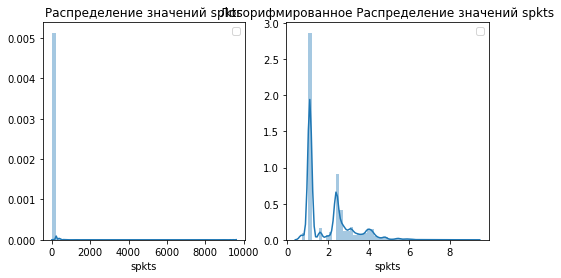

No handles with labels found to put in legend.


Описание параметра  dpkts
доля пропусков : 0.0 
 min : 0 
 25-й перцентиль: 0.0 
 медиана: 2.0 
 среднее: 18.969590683297117 
 max : 10974 
 75-й перцентиль: 10.0 
 IQR: 10.0 
 Границы выбросов: [-15.0, 25.0] 



No handles with labels found to put in legend.


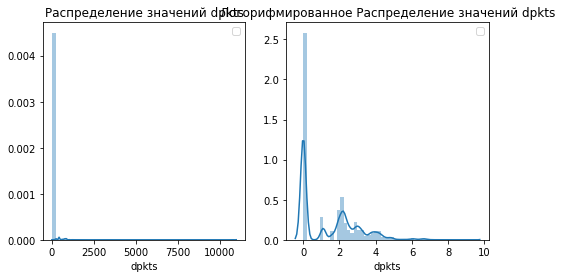

Описание параметра  sbytes
доля пропусков : 0.0 
 min : 28 
 25-й перцентиль: 114.0 
 медиана: 430.0 
 среднее: 8844.843835725815 
 max : 12965233 
 75-й перцентиль: 1418.0 
 IQR: 1304.0 
 Границы выбросов: [-1842.0, 3374.0] 



No handles with labels found to put in legend.
No handles with labels found to put in legend.


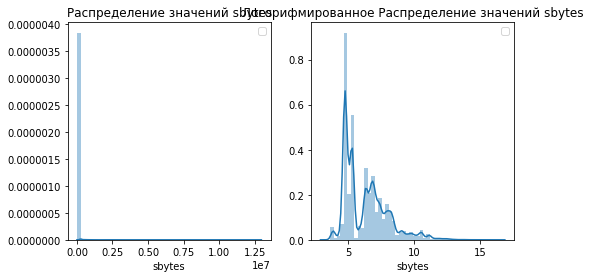

No handles with labels found to put in legend.


Описание параметра  dbytes
доля пропусков : 0.0 
 min : 0 
 25-й перцентиль: 0.0 
 медиана: 164.0 
 среднее: 14928.918564397374 
 max : 14655550 
 75-й перцентиль: 1102.0 
 IQR: 1102.0 
 Границы выбросов: [-1653.0, 2755.0] 



No handles with labels found to put in legend.


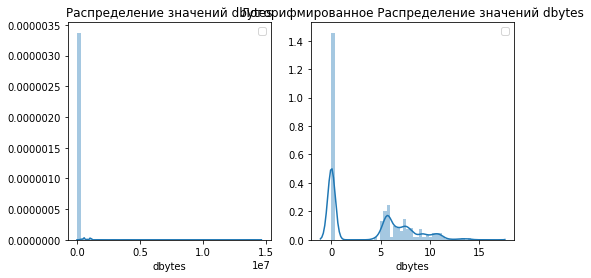

No handles with labels found to put in legend.


Описание параметра  rate
доля пропусков : 0.0 
 min : 0.0 
 25-й перцентиль: 32.78614 
 медиана: 3225.80652 
 среднее: 95406.18710525581 
 max : 1000000.003 
 75-й перцентиль: 125000.0003 
 IQR: 124967.21416 
 Границы выбросов: [-187418.0351, 312450.82154000003] 



No handles with labels found to put in legend.


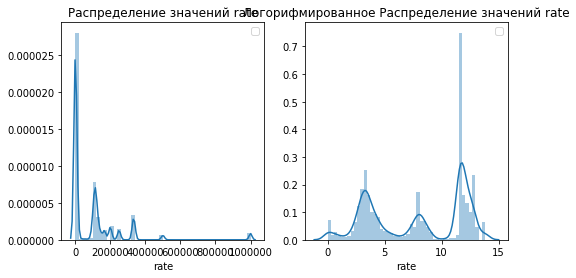

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Описание параметра  sttl
доля пропусков : 0.0 
 min : 0 
 25-й перцентиль: 62.0 
 медиана: 254.0 
 среднее: 179.546996994428 
 max : 255 
 75-й перцентиль: 254.0 
 IQR: 192.0 
 Границы выбросов: [-226.0, 542.0] 



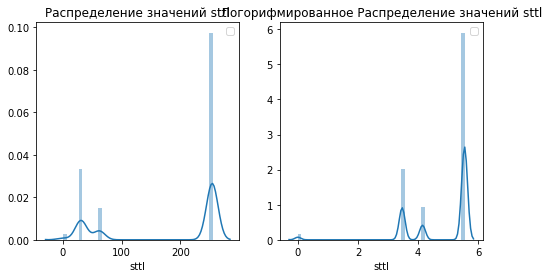

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Описание параметра  dttl
доля пропусков : 0.0 
 min : 0 
 25-й перцентиль: 0.0 
 медиана: 29.0 
 среднее: 79.60956650184498 
 max : 254 
 75-й перцентиль: 252.0 
 IQR: 252.0 
 Границы выбросов: [-378.0, 630.0] 



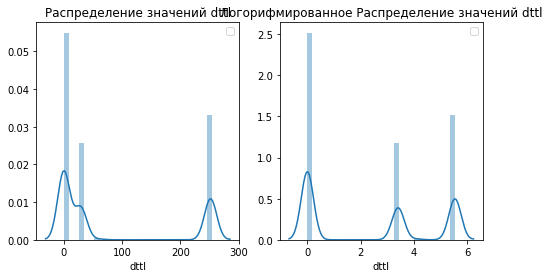

No handles with labels found to put in legend.


Описание параметра  sload
доля пропусков : 0.0 
 min : 0.0 
 25-й перцентиль: 13053.33887 
 медиана: 879674.75 
 среднее: 73454033.19406345 
 max : 5988000256.0 
 75-й перцентиль: 88888888.0 
 IQR: 88875834.66113 
 Границы выбросов: [-133300698.65282498, 222202639.991695] 



No handles with labels found to put in legend.


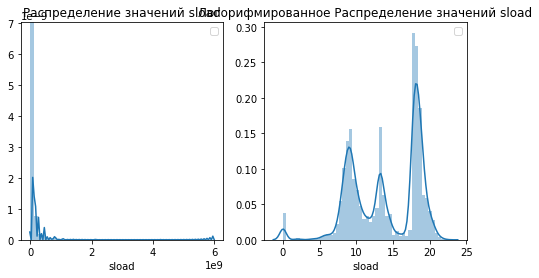

No handles with labels found to put in legend.


Описание параметра  dload
доля пропусков : 0.0 
 min : 0.0 
 25-й перцентиль: 0.0 
 медиана: 1447.022705 
 среднее: 671205.5741882676 
 max : 22422730.0 
 75-й перцентиль: 27844.871089999997 
 IQR: 27844.871089999997 
 Границы выбросов: [-41767.30663499999, 69612.17772499999] 



No handles with labels found to put in legend.


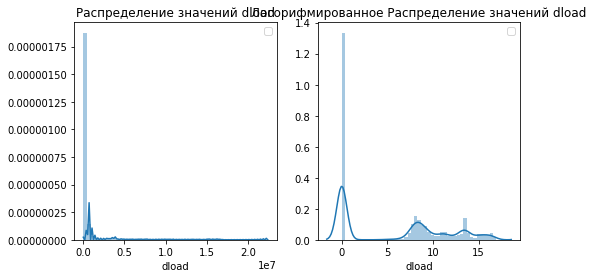

No handles with labels found to put in legend.


Описание параметра  sinpkt
доля пропусков : 0.0 
 min : 0.0 
 25-й перцентиль: 0.008 
 медиана: 0.279733 
 среднее: 985.9768636751918 
 max : 84371.496 
 75-й перцентиль: 55.156895999999996 
 IQR: 55.14889599999999 
 Границы выбросов: [-82.715344, 137.88024] 



No handles with labels found to put in legend.


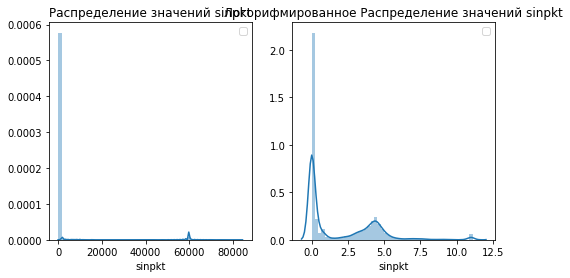

No handles with labels found to put in legend.


Описание параметра  dinpkt
доля пропусков : 0.0 
 min : 0.0 
 25-й перцентиль: 0.0 
 медиана: 0.006 
 среднее: 88.21629640844522 
 max : 56716.824 
 75-й перцентиль: 51.053000000000004 
 IQR: 51.053000000000004 
 Границы выбросов: [-76.57950000000001, 127.63250000000002] 



No handles with labels found to put in legend.


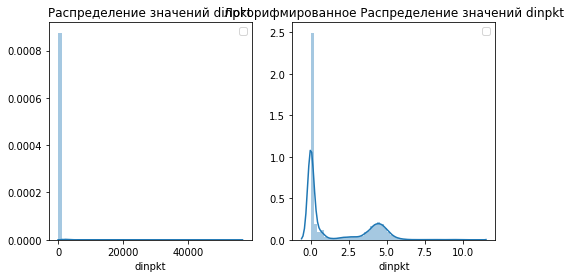

No handles with labels found to put in legend.


Описание параметра  sjit
доля пропусков : 0.0 
 min : 0.0 
 25-й перцентиль: 0.0 
 медиана: 0.0 
 среднее: 4976.254226211929 
 max : 1460480.0159999998 
 75-й перцентиль: 2513.295019 
 IQR: 2513.295019 
 Границы выбросов: [-3769.9425285, 6283.237547500001] 



No handles with labels found to put in legend.


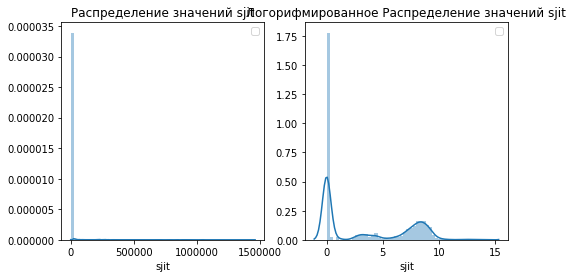

No handles with labels found to put in legend.


Описание параметра  djit
доля пропусков : 0.0 
 min : 0.0 
 25-й перцентиль: 0.0 
 медиана: 0.0 
 среднее: 604.3538264155093 
 max : 289388.2697 
 75-й перцентиль: 114.990625 
 IQR: 114.990625 
 Границы выбросов: [-172.48593749999998, 287.4765625] 



No handles with labels found to put in legend.


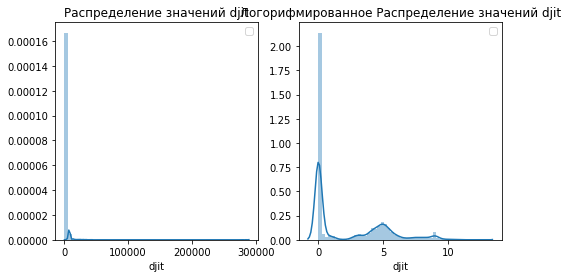

No handles with labels found to put in legend.


Описание параметра  swin
доля пропусков : 0.0 
 min : 0 
 25-й перцентиль: 0.0 
 медиана: 0.0 
 среднее: 116.25733855743951 
 max : 255 
 75-й перцентиль: 255.0 
 IQR: 255.0 
 Границы выбросов: [-382.5, 637.5] 



No handles with labels found to put in legend.


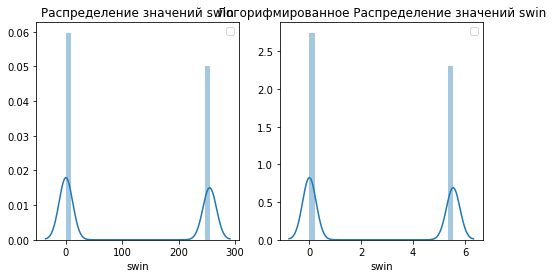

No handles with labels found to put in legend.


Описание параметра  stcpb
доля пропусков : 0.0 
 min : 0 
 25-й перцентиль: 0.0 
 медиана: 0.0 
 среднее: 969250421.9105115 
 max : 4294958913 
 75-й перцентиль: 1916651334.0 
 IQR: 1916651334.0 
 Границы выбросов: [-2874977001.0, 4791628335.0] 



No handles with labels found to put in legend.


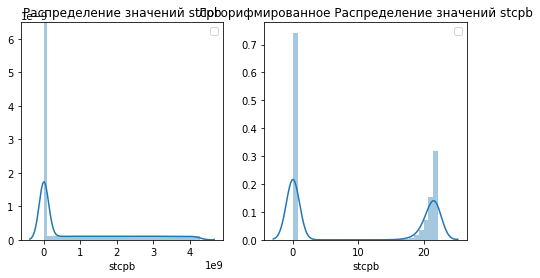

No handles with labels found to put in legend.


Описание параметра  dtcpb
доля пропусков : 0.0 
 min : 0 
 25-й перцентиль: 0.0 
 медиана: 0.0 
 среднее: 968877027.0711528 
 max : 4294881924 
 75-й перцентиль: 1913674673.0 
 IQR: 1913674673.0 
 Границы выбросов: [-2870512009.5, 4784186682.5] 



No handles with labels found to put in legend.


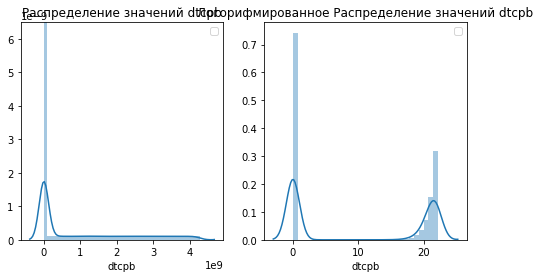

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Описание параметра  dwin
доля пропусков : 0.0 
 min : 0 
 25-й перцентиль: 0.0 
 медиана: 0.0 
 среднее: 115.01362487952048 
 max : 255 
 75-й перцентиль: 255.0 
 IQR: 255.0 
 Границы выбросов: [-382.5, 637.5] 



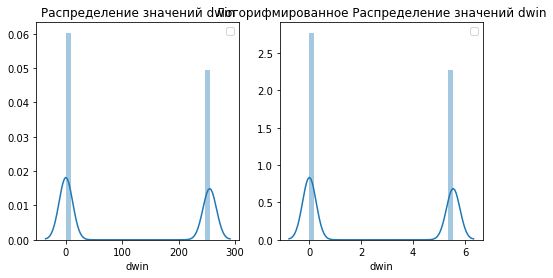

No handles with labels found to put in legend.


Описание параметра  tcprtt
доля пропусков : 0.0 
 min : 0.0 
 25-й перцентиль: 0.0 
 медиана: 0.0 
 среднее: 0.041395644355855084 
 max : 2.518893 
 75-й перцентиль: 0.065481 
 IQR: 0.065481 
 Границы выбросов: [-0.09822149999999999, 0.16370249999999997] 



No handles with labels found to put in legend.


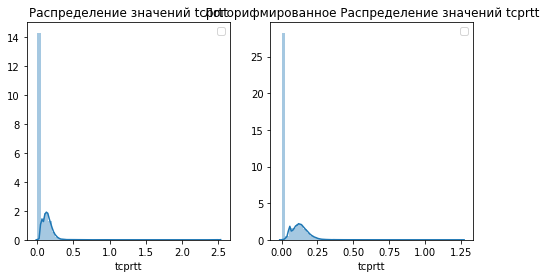

No handles with labels found to put in legend.


Описание параметра  synack
доля пропусков : 0.0 
 min : 0.0 
 25-й перцентиль: 0.0 
 медиана: 0.0 
 среднее: 0.021020450476500106 
 max : 2.100352 
 75-й перцентиль: 0.023268 
 IQR: 0.023268 
 Границы выбросов: [-0.034902, 0.05817] 



No handles with labels found to put in legend.


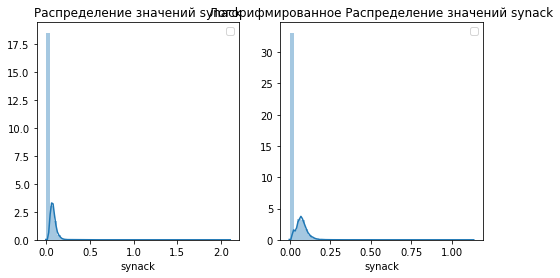

No handles with labels found to put in legend.


Описание параметра  ackdat
доля пропусков : 0.0 
 min : 0.0 
 25-й перцентиль: 0.0 
 медиана: 0.0 
 среднее: 0.020375193879355186 
 max : 1.5208840000000001 
 75-й перцентиль: 0.038906 
 IQR: 0.038906 
 Границы выбросов: [-0.05835900000000001, 0.09726500000000002] 



No handles with labels found to put in legend.


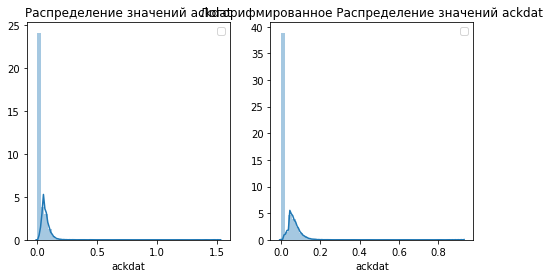

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Описание параметра  smean
доля пропусков : 0.0 
 min : 28 
 25-й перцентиль: 57.0 
 медиана: 73.0 
 среднее: 136.7517694093224 
 max : 1504 
 75-й перцентиль: 100.0 
 IQR: 43.0 
 Границы выбросов: [-7.5, 164.5] 



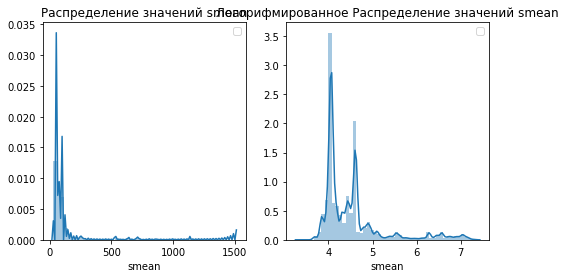

No handles with labels found to put in legend.


Описание параметра  dmean
доля пропусков : 0.0 
 min : 0 
 25-й перцентиль: 0.0 
 медиана: 44.0 
 среднее: 124.17338215249143 
 max : 1458 
 75-й перцентиль: 89.0 
 IQR: 89.0 
 Границы выбросов: [-133.5, 222.5] 



No handles with labels found to put in legend.


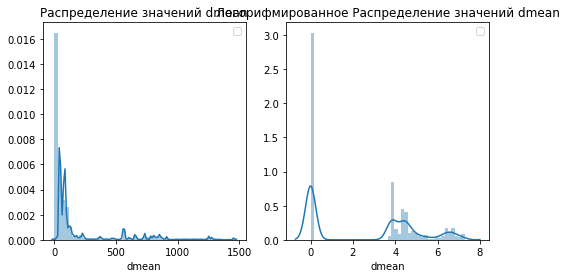

Описание параметра  trans_depth
доля пропусков : 0.0 
 min : 0 
 25-й перцентиль: 0.0 
 медиана: 0.0 
 среднее: 0.10598205781876457 
 max : 172 
 75-й перцентиль: 0.0 
 IQR: 0.0 
 Границы выбросов: [0.0, 0.0] 



RuntimeError: Selected KDE bandwidth is 0. Cannot estiamte density.

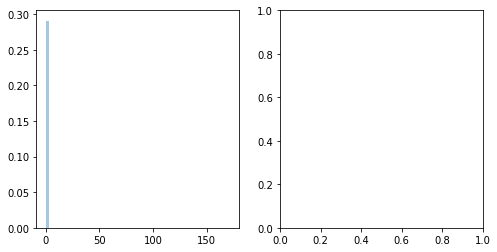

In [10]:
#сделаем разведку наших числовых параметров
#параметров много потому сделаем в цикле
for i in num_params:
    num_describer(data,i)

In [11]:
def obj_param_describe(df,param):
    print('доля пропусков: ',df[param].isnull().sum()/len(df[param]))
    print('Значения параметра и их количество')
    df[param].value_counts().plot.bar()
    print(df[param].value_counts())

Сделаем осмотр категорийных параметров.
При классификации для категорийных параметров используют OneHotEncoding.
Это когда напимер столбец proto удаляется , вместо него генерируется столбцы с названиями tcp,udp,unas,.....
В них ставятся 1 и 0. в столбце tcp 1 будут у тех, у кого в столбце proto было значение tcp
В нашем слечае это будет не совсем правильно. Из-за увеличения количество столбцов увеличится размерность векторного пространства, т.к. у нас евклидово расстояние то увеличение размерности приведет к тому что относительное расстояние между точками уменьшится и упадет качество кластеризации.

доля пропусков:  0.0
Значения параметра и их количество
tcp      79946
udp      63283
unas     12084
arp       2859
ospf      2595
         ...  
argus       98
hmp         98
igmp        18
icmp        15
rtp          1
Name: proto, Length: 133, dtype: int64


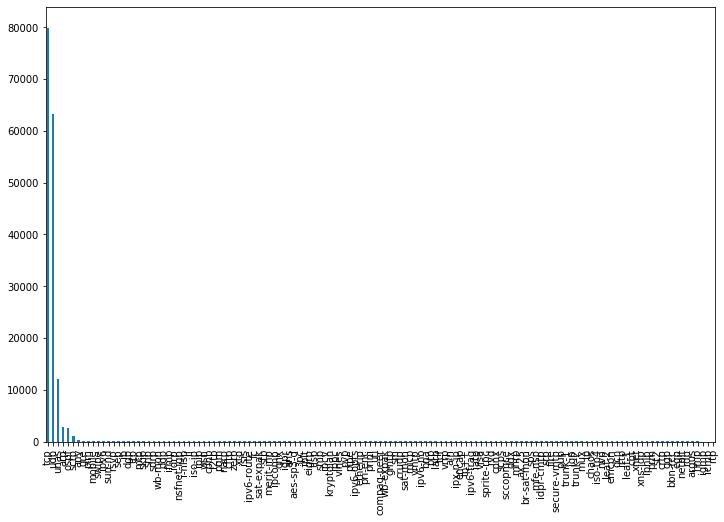

In [12]:
obj_param_describe(data,'proto')

доля пропусков:  0.0
Значения параметра и их количество
-           94168
dns         47294
http        18724
smtp         5058
ftp-data     3995
ftp          3428
ssh          1302
pop3         1105
dhcp           94
snmp           80
ssl            56
irc            25
radius         12
Name: service, dtype: int64


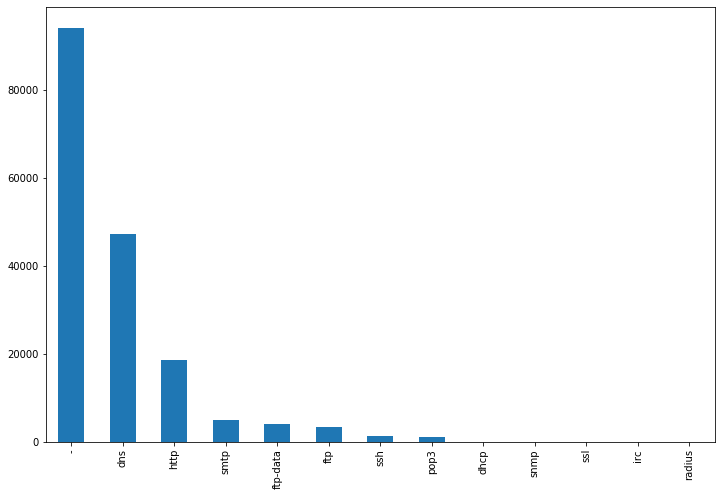

In [13]:
obj_param_describe(data,'service')

доля пропусков:  0.0
Значения параметра и их количество
INT    82275
FIN    77825
CON    13152
REQ     1991
RST       83
ECO       12
URN        1
no         1
PAR        1
Name: state, dtype: int64


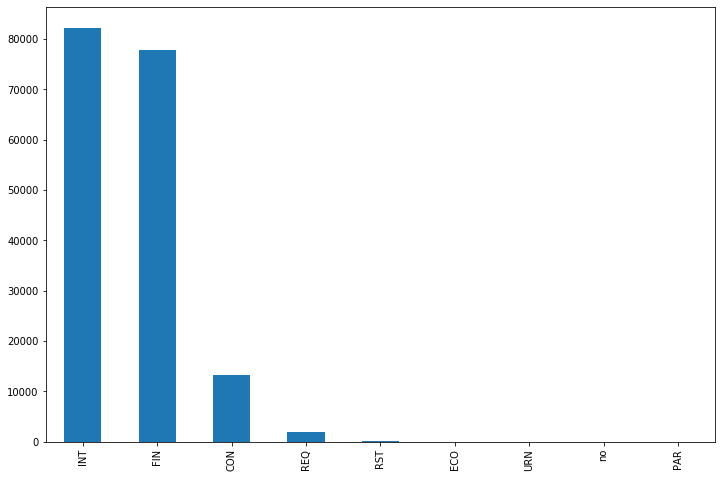

In [14]:
obj_param_describe(data,'state')

доля пропусков:  0.0
Значения параметра и их количество
Normal            56000
Generic           40000
Exploits          33393
Fuzzers           18184
DoS               12264
Reconnaissance    10491
Analysis           2000
Backdoor           1746
Shellcode          1133
Worms               130
Name: attack_cat, dtype: int64


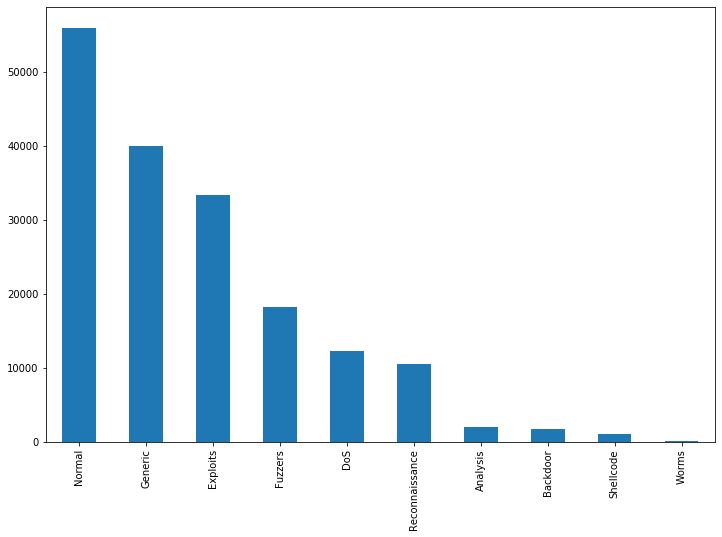

In [15]:
#вот типы атак и будут нашими классами на которые мы будем кластеризовать. 
obj_param_describe(data,'attack_cat')

# Готовим датасет


In [6]:
data_res=data.drop(['id','state','service','proto','label'],axis=1)#удаляем ненужные столбцы

In [114]:
data_res=data_res.drop(['cluster_label_agglomerative'],axis=1)
data_res

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,cluster_label_kmeans
0,0.121478,6,4,258,172,74.087490,252,254,1.415894e+04,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,Normal,8
1,0.649902,14,38,734,42014,78.473372,62,252,8.395112e+03,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,Normal,2
2,1.623129,8,16,364,13186,14.170161,62,252,1.572272e+03,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,Normal,7
3,1.681642,12,12,628,770,13.677108,62,252,2.740179e+03,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,Normal,4
4,0.449454,10,6,534,268,33.373826,254,252,8.561499e+03,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,Normal,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,0.000009,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,24,2,24,24,13,24,0,0,0,24,24,0,Generic,1
175337,0.505762,10,8,620,354,33.612649,254,252,8.826286e+03,4903.492188,2,1,54.400111,66.980570,3721.068786,120.177727,255,3518776216,3453092386,255,0.099440,0.036895,0.062545,62,44,0,0,1,1,1,1,1,2,0,0,0,1,1,0,Shellcode,5
175338,0.000009,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,12,2,3,3,3,13,0,0,0,3,12,0,Generic,1
175339,0.000009,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,30,2,30,30,14,30,0,0,0,30,30,0,Generic,1


In [54]:
#алгоритмы работают с матрицами или векторами, потому dataframe подать на вход не получится
#берем только значения

X_data=(data_res.drop(['attack_cat'],axis=1).values)
X_data2=(data_res.drop(['attack_cat'],axis=1).values)[0:2]

for i in range(25000): X_data2 = np.append(X_data2, [X_data[np.random.randint(0, len(X_data))]], axis = 0)

Y_data=data_res.attack_cat.values
#X_data
len(X_data2)

25002

In [83]:
Y_data

array(['Normal', 'Normal', 'Normal', ..., 'Generic', 'Generic', 'Generic'],
      dtype=object)

# K-means

Выберем оптимальное количество кластеров для наших данных: в нашем случае, это 10 кластеров(по виду атак), один из которых в центре. Добавим случайным образом 10 центроидов. (центроиды — предполагаемые центры будущих кластеров) Для каждой точки мы можем посчитать, к какому центроиду она ближе. Перенесём центроид в центр выборки, к которой мы его отнесли: то есть, расположим его так. чтобы расстояния от объектов кластера до центроида были как можно меньше.. Повторим эти шаги, пока алгоритм не сойдётся.

In [29]:
from sklearn.cluster import KMeans

k_means = KMeans(n_clusters=10,  #количество кластеров
                 init='k-means++', # 'k-means++', 'random', numpy.array метод инициализации
                 max_iter=1000 #максимальное количество итераций
                )
k_means.fit(X_data)#запускаем кластеризацию

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [30]:
#выведем метки кластера которые выдал наш алгоритм для обучающей выборки
k_means.labels_

array([8, 2, 7, ..., 1, 1, 1])

In [36]:
#Приклеим наши предсказания к датасету data_res 
#Если отлистать датасет к конце и посмотреть на столбцы attack_cat 	cluster_label видно что много ошибок даже по первым
#строкам где класс normal. Основные причины:
#Большая размерность пространства
#Алгоритмы кластеризации не могут обрабатывать категорийные параметры, а если их включить то только усугубим проблему 1
#
#
data_res['cluster_label_kmeans']=pd.DataFrame(k_means.labels_)
data_res

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,cluster_label_kmeans
0,0.121478,6,4,258,172,74.087490,252,254,1.415894e+04,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,Normal,8
1,0.649902,14,38,734,42014,78.473372,62,252,8.395112e+03,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,Normal,2
2,1.623129,8,16,364,13186,14.170161,62,252,1.572272e+03,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,Normal,7
3,1.681642,12,12,628,770,13.677108,62,252,2.740179e+03,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,Normal,4
4,0.449454,10,6,534,268,33.373826,254,252,8.561499e+03,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,Normal,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,0.000009,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,24,2,24,24,13,24,0,0,0,24,24,0,Generic,1
175337,0.505762,10,8,620,354,33.612649,254,252,8.826286e+03,4903.492188,2,1,54.400111,66.980570,3721.068786,120.177727,255,3518776216,3453092386,255,0.099440,0.036895,0.062545,62,44,0,0,1,1,1,1,1,2,0,0,0,1,1,0,Shellcode,5
175338,0.000009,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,12,2,3,3,3,13,0,0,0,3,12,0,Generic,1
175339,0.000009,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,30,2,30,30,14,30,0,0,0,30,30,0,Generic,1


In [35]:
data_res['cluster_label_kmeans'].value_counts()

1    99032
5    10093
4     9581
2     9052
7     8911
3     8243
9     7962
8     7953
0     7291
6     7223
Name: cluster_label_kmeans, dtype: int64

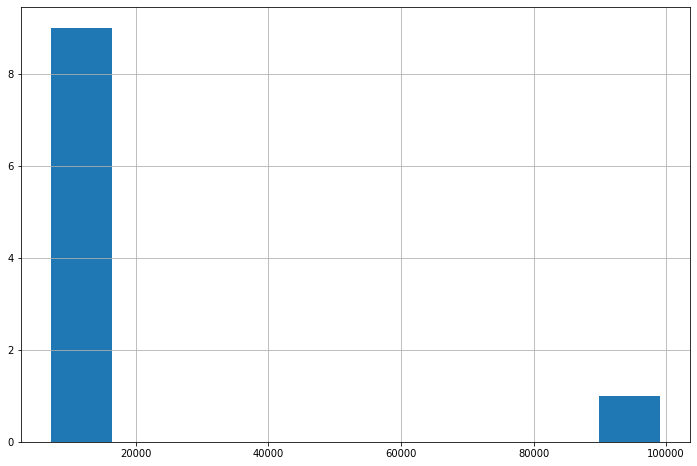

In [34]:
data_res['cluster_label_kmeans'].value_counts().hist()

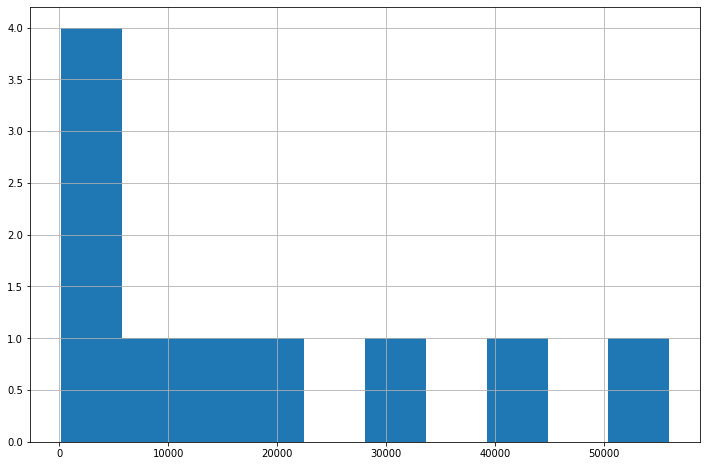

In [33]:
data_res['attack_cat'].value_counts().hist()

Если сравнить 2 гистограммы выше , видно что пропорция классов/кластеров нарушилась

In [32]:
#посмотрим на координаты центров кластера для каждого кластера. 
#из-за большой размерности получается не особо информативно
#выведем координаты центров кластеров
k_means.cluster_centers_

array([[ 1.49066550e+00,  3.91640085e+01,  3.58354891e+01,
         2.18189965e+04,  2.70799691e+04,  6.91805810e+02,
         1.40691950e+02,  1.84520281e+02,  3.61367297e+05,
         1.13388017e+06,  1.16947130e+01,  1.29221399e+01,
         1.27478419e+02,  1.69464403e+02,  1.10134719e+04,
         1.28643845e+03,  2.55000000e+02,  3.47935026e+09,
         8.45381156e+08,  2.54966596e+02,  1.00300938e-01,
         5.10889975e-02,  4.92119402e-02,  1.74610825e+02,
         2.40621751e+02,  2.56812759e-01,  4.31343564e+03,
         3.75624765e+00,  7.24852443e-01,  2.45937461e+00,
         1.41956549e+00,  1.06806480e+00,  2.77320105e+00,
         3.67951777e-02,  3.67951777e-02,  3.13575286e-01,
         3.14316212e+00,  3.37510988e+00, -1.31838984e-16],
       [ 1.25687572e+00,  5.12971734e+00,  2.13838199e+00,
         1.29759551e+03,  1.60192788e+03,  1.68274622e+05,
         2.15863294e+02,  7.64112378e+00,  1.29721463e+08,
         1.31721792e+05,  3.63248942e-01,  6.75439039e-

In [31]:
#после того как мы провели кластеризацию и известны центры кластеров для новых объектов можно сразу считать к какому кластеру
#он относится#
#пример на первой строке датасета
answer=k_means.predict(np.array([X_data[0]]))
answer[0]

8

Примеры

In [37]:
#генерирую разные датасеты под разные случаи

# Количество объектов в каждом датасете
n_samples = 1500

# Вписанные круги
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
# Оставляем только признаки датасета, так как для кластеризации нам не нужны истинные классы объектов
X, y = noisy_circles
noisy_circles = X

# Полукруги
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
X, y = noisy_moons
noisy_moons = X

# Кластеры в форме круга
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
X, y = blobs
blobs = X

# Отсутствие кластерной структуры
no_structure = np.random.rand(n_samples, 2)

# Кластеры лентовидной формы
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = X_aniso

# Кластеры в форме кругов с различной дисперсией
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)
X, y = varied
varied = X

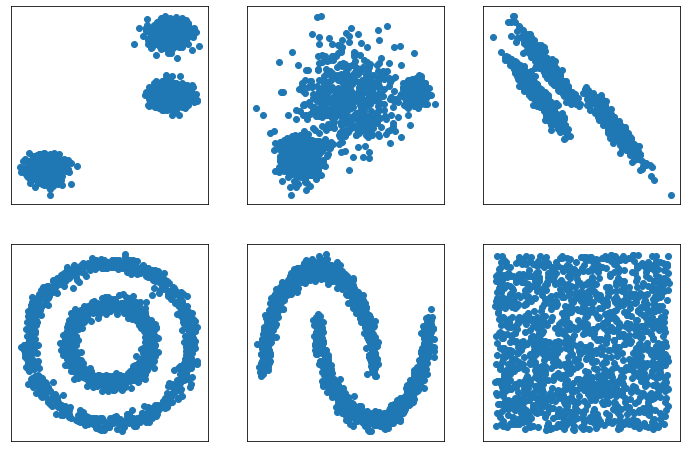

In [38]:
datasets_list = [blobs, varied, aniso, noisy_circles, noisy_moons, no_structure]#список датасетов
for i, X in enumerate(datasets_list, start=1):#визуализация
    plt.subplot(f'23{i}')
    plt.xticks([]); plt.yticks([])
    plt.scatter(X[:, 0], X[:, 1])

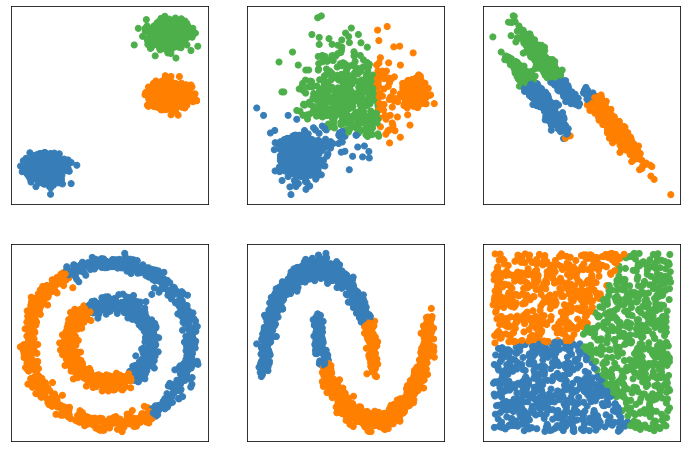

In [39]:
# создаём массив пар – датасета и соответствующих для него параметров алгоритма
datasets_params_list = [
    (blobs, {'n_clusters': 3}),
    (varied, {'n_clusters': 3}),
    (aniso, {'n_clusters': 3}),
    (noisy_circles, {'n_clusters': 2}),
    (noisy_moons, {'n_clusters': 2}),
    (no_structure, {'n_clusters': 3})]
#каждый датасет кластеризуем и отрисовываем
for i, (X, k_means_params) in enumerate(datasets_params_list, start=1):
    X = StandardScaler().fit_transform(X)
    k_means_my = KMeans(n_clusters=k_means_params['n_clusters'])
    
    k_means_my.fit(X)
    y_pred = k_means_my.labels_.astype(np.int)

    plt.subplot(f'23{i}')
    plt.xticks([]); plt.yticks([])
    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                         '#f781bf', '#a65628', '#984ea3',
                                         '#999999', '#e41a1c', '#dede00']),
                                  int(max(y_pred) + 1))))
    plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred])

# Агломеративная кластеризация

In [55]:
from sklearn.cluster import AgglomerativeClustering

ac = AgglomerativeClustering(n_clusters=9,
                             affinity='euclidean', # “euclidean”, “l1”, “l2”, “manhattan”, 
                                                   # “cosine”, or “precomputed”
                             linkage='ward', # “ward”, “complete”, “average”, “single”
                            )

In [56]:

ac.fit(X_data2)# кластеризуем
ac.labels_

array([1, 7, 2, ..., 2, 2, 2], dtype=int64)

In [57]:

a = ac.labels_
_, counts = np.unique(a, return_counts=True)
for count in counts:
    print(count, end=' ')

1949 1677 13771 1430 1251 1892 807 1315 910 

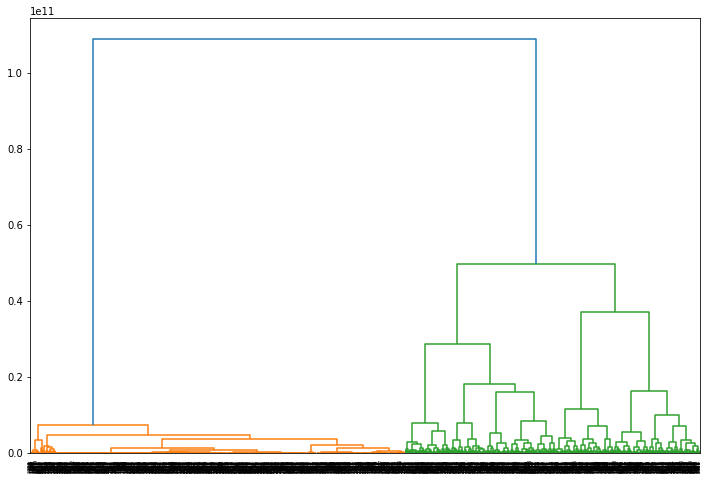

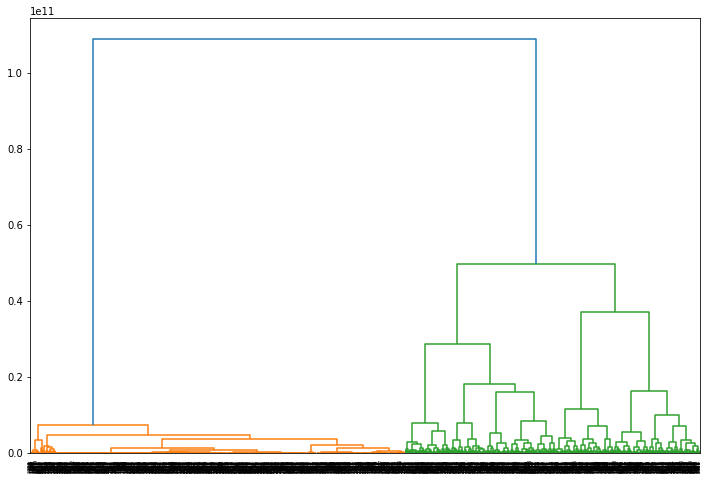

In [59]:
from scipy.cluster.hierarchy import dendrogram, linkage

# подготовим данные для построения дендрограммы
# ещё один способ выполнить агломеративную кластеризацию
# по сути это будет просто наглядная визуализация
#
Z = linkage(X_data2[0:2500], "ward")

# строим дендрограмму
dendrogram(Z, leaf_rotation=90.)

#визуализируем наше дерево
fig = plt.figure()
dendrogram(Z,p=200, leaf_rotation=90.)
plt.show()

Примеры не из нашей сферы

In [72]:
from sklearn.cluster import AgglomerativeClustering

ac = AgglomerativeClustering(n_clusters=3,
                             affinity='euclidean', # “euclidean”, “l1”, “l2”, “manhattan”, 
                                                   # “cosine”, or “precomputed”
                             linkage='ward', # “ward”, “complete”, “average”, “single”
                            )

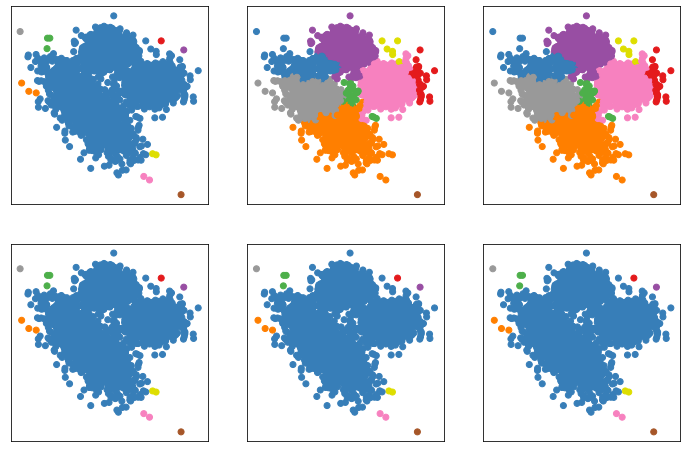

In [182]:
from sklearn.neighbors import kneighbors_graph

datasets_params_list = [
    (blobs, {'n_clusters': 9, 'n_neighbors': 10}),
    (varied, {'n_clusters': 9, 'n_neighbors': 2}),
    (aniso, {'n_clusters': 9, 'n_neighbors': 2}),
    (noisy_circles, {'n_clusters': 9, 'n_neighbors': 10}),
    (noisy_moons, {'n_clusters': 9, 'n_neighbors': 10}),
    (no_structure, {'n_clusters': 9, 'n_neighbors': 10})]

for i, (X_data, ac_params) in enumerate(datasets_params_list, start=1):
    X = StandardScaler().fit_transform(X)
    
    # строим матрицу смежности
    connectivity = kneighbors_graph(X, 
                                    n_neighbors=ac_params['n_neighbors'], 
                                    include_self=False)
    # делаем матрицу смежности симметричной
    connectivity = 0.5 * (connectivity + connectivity.T)
    
    ac = AgglomerativeClustering(n_clusters=ac_params['n_clusters'], 
                                 linkage='average',
                                 connectivity=connectivity)
    
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="the number of connected components of the " +
            "connectivity matrix is [0-9]{1,2}" +
            " > 1. Completing it to avoid stopping the tree early.",
            category=UserWarning)
        ac.fit(X)
    y_pred = ac.labels_.astype(np.int)

    plt.subplot(f'23{i}')
    plt.xticks([]); plt.yticks([])
    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                         '#f781bf', '#a65628', '#984ea3',
                                         '#999999', '#e41a1c', '#dede00']),
                                  int(max(y_pred) + 1))))
    plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred])

# DBSCAN

In [80]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=10000,
                min_samples=10)

In [119]:
dbscan.fit(X_data)

DBSCAN(algorithm='auto', eps=10000, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=10, n_jobs=None, p=None)

In [120]:
label_list=dbscan.labels_.tolist()#получили метки кластера
len(set(label_list))#получили количество уникальных меток

189

In [122]:
dbscan1= DBSCAN(eps=100000,
                min_samples=10)
dbscan1.fit(X_data)
label_list=dbscan1.labels_.tolist()#получили метки кластера
len(set(label_list))#получили количество уникальных меток

163

In [124]:
dbscan1= DBSCAN(eps=100000,
                min_samples=20)
dbscan1.fit(X_data2)
label_list=dbscan1.labels_.tolist()#получили метки кластера
len(set(label_list))#получили количество уникальных меток

120

In [125]:
dbscan1= DBSCAN(eps=150000,
                min_samples=30)
dbscan1.fit(X_data)
label_list=dbscan1.labels_.tolist()#получили метки кластера
len(set(label_list))#получили количество уникальных меток

92

In [126]:
data_res['cluster_label_dbscan']=pd.DataFrame(dbscan.labels_)
data_res

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,cluster_label_kmeans,cluster_label_dbscan
0,0.121478,6,4,258,172,74.087490,252,254,1.415894e+04,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,Normal,8,-1
1,0.649902,14,38,734,42014,78.473372,62,252,8.395112e+03,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,Normal,2,-1
2,1.623129,8,16,364,13186,14.170161,62,252,1.572272e+03,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,Normal,7,-1
3,1.681642,12,12,628,770,13.677108,62,252,2.740179e+03,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,Normal,4,-1
4,0.449454,10,6,534,268,33.373826,254,252,8.561499e+03,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,Normal,3,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,0.000009,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,24,2,24,24,13,24,0,0,0,24,24,0,Generic,1,161
175337,0.505762,10,8,620,354,33.612649,254,252,8.826286e+03,4903.492188,2,1,54.400111,66.980570,3721.068786,120.177727,255,3518776216,3453092386,255,0.099440,0.036895,0.062545,62,44,0,0,1,1,1,1,1,2,0,0,0,1,1,0,Shellcode,5,-1
175338,0.000009,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,12,2,3,3,3,13,0,0,0,3,12,0,Generic,1,161
175339,0.000009,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,0,0,0.009000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,30,2,30,30,14,30,0,0,0,30,30,0,Generic,1,161


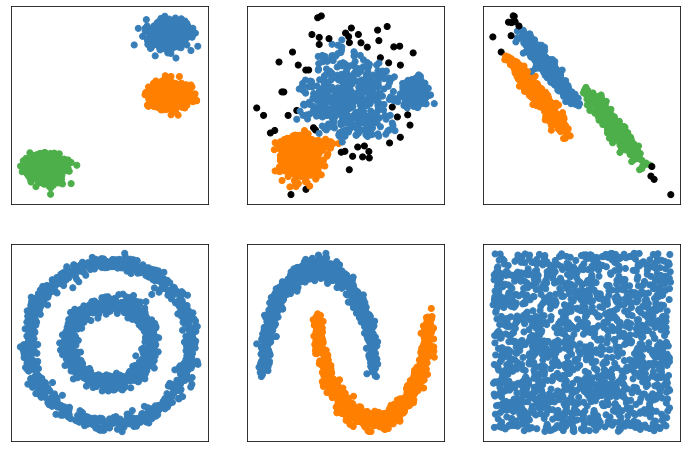

In [127]:
datasets_params_list = [
    (blobs, {'eps': 0.3}),
    (varied, {'eps': 0.18}),
    (aniso, {'eps': 0.184}),
    (noisy_circles, {'eps': 0.3}),
    (noisy_moons, {'eps': 0.3}),
    (no_structure, {'eps': 0.3})]

for i, (X, dbscan_params) in enumerate(datasets_params_list, start=1):
    X = StandardScaler().fit_transform(X)
    dbscan = DBSCAN(eps=dbscan_params['eps'])
    
    dbscan.fit(X)
    y_pred = dbscan.labels_.astype(np.int)

    plt.subplot(f'23{i}')
    plt.xticks([]); plt.yticks([])
    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                         '#f781bf', '#a65628', '#984ea3',
                                         '#999999', '#e41a1c', '#dede00']),
                                  int(max(y_pred) + 1))))
    # чёрным цветом отметим выбросы
    colors = np.append(colors, ["#000000"])
    plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred])
    
    #черным отмечено то что не было кластеризовано вообще никак
    #
    #
    #

# Метрики качества

# Коэффициент силуэта

Значение силуэта показывает, насколько объект похож на свой кластер по сравнению с другими кластерами. a - среднее расстояние от данного объекта до объектов из того же кластера. b — среднее расстояние от данного объекта до объектов из ближайшего кластера. s=(b-a)/max(a,b)

In [128]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

n_samples = 1500
dataset = datasets.make_blobs(n_samples=n_samples, centers=2, center_box=(-7.0, 7.5),
                              cluster_std=[1.4, 1.7],
                              random_state=42)
X_2, _ = datasets.make_blobs(n_samples=n_samples, random_state=170, centers=[[-4, -3]], cluster_std=[1.9])
transformation = [[1.2, -0.8], [-0.4, 1.7]]
X_2 = np.dot(X_2, transformation)
X, y = np.concatenate((dataset[0], X_2)), np.concatenate((dataset[1], np.array([2] * len(X_2))))

Коэффициент силуэта можно посчитать при помощи реализации из библиотеки sklearn

In [129]:
from sklearn.metrics import silhouette_score

# сначала получим предсказанные кластеры при помощи метода кластеризации
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)
kmeans_pred = kmeans.labels_

# теперь посчитаем коэффициент силуэта
a=silhouette_score(X=X, labels=kmeans_pred, metric='euclidean')
print('коэффициент силуэта для алгоритма KMeans ',a)

коэффициент силуэта для алгоритма KMeans  0.5131209788437305


In [130]:
ac = AgglomerativeClustering(n_clusters=3,
                             affinity='euclidean', # “euclidean”, “l1”, “l2”, “manhattan”, 
                                                   # “cosine”, or “precomputed”
                             linkage='ward', # “ward”, “complete”, “average”, “single”
                            )
ac.fit(X)
ac_pred=ac.labels_
a=silhouette_score(X=X, labels=ac_pred, metric='euclidean')
print('коэффициент силуэта для алгоритма AgglomerativeClustering ',a)


коэффициент силуэта для алгоритма AgglomerativeClustering  0.4811992210663849


In [131]:
dbscan= DBSCAN(eps=0.1,
                min_samples=5)
dbscan.fit(X)
dbscan_pred=dbscan.labels_
a=silhouette_score(X=X, labels=dbscan_pred, metric='euclidean')
print('коэффициент силуэта для алгоритма DBSCAN ',a)

коэффициент силуэта для алгоритма DBSCAN  -0.7191390558031996


Как видно на одних и тех же данных у разных алгоритмов разное качество. потому что как и везде каждый алгоритм под свою задачу

# Внешние метрики

In [132]:
from sklearn.metrics.cluster import homogeneity_score
from sklearn.preprocessing import StandardScaler
# сначала получим предсказанные кластеры при помощи метода кластеризации
kmeans = KMeans(n_clusters=3, random_state=42)
X = StandardScaler().fit_transform(X)
kmeans.fit(X)
kmeans_pred = kmeans.labels_ # теперь посчитаем однородность 
homogeneity_score(labels_true=y, labels_pred=kmeans_pred)

0.804474693112785

In [133]:
ac = AgglomerativeClustering(n_clusters=3,
                             affinity='euclidean', # “euclidean”, “l1”, “l2”, “manhattan”, 
                                                   # “cosine”, or “precomputed”
                             linkage='ward', # “ward”, “complete”, “average”, “single”
                            )
X = StandardScaler().fit_transform(X)
ac.fit(X)
ac_pred = ac.labels_ # теперь посчитаем однородность 
homogeneity_score(labels_true=y, labels_pred=ac_pred)

0.9099781767383747

In [134]:
dbscan= DBSCAN(eps=0.1,
                min_samples=5)
X = StandardScaler().fit_transform(X)
dbscan.fit(X)
dbscan_pred = dbscan.labels_ # теперь посчитаем однородность 
homogeneity_score(labels_true=y, labels_pred=dbscan_pred)

0.8828600384511835

# Полнота

In [135]:
from sklearn.metrics.cluster import completeness_score

# сначала получим предсказанные кластеры при помощи метода кластеризации
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)
kmeans_pred = kmeans.labels_

# теперь посчитаем полноту
completeness_score(labels_true=y, labels_pred=kmeans_pred)

0.7828224102025245

In [136]:
ac = AgglomerativeClustering(n_clusters=3,
                             affinity='euclidean', # “euclidean”, “l1”, “l2”, “manhattan”, 
                                                   # “cosine”, or “precomputed”
                             linkage='ward', # “ward”, “complete”, “average”, “single”
                            )
X = StandardScaler().fit_transform(X)
ac.fit(X)
ac_pred = ac.labels_ # теперь посчитаем однородность 
completeness_score(labels_true=y, labels_pred=ac_pred)

0.9058386997451113

In [137]:
dbscan= DBSCAN(eps=0.1,
                min_samples=5)
X = StandardScaler().fit_transform(X)
dbscan.fit(X)
dbscan_pred = dbscan.labels_ # теперь посчитаем однородность 
completeness_score(labels_true=y, labels_pred=dbscan_pred)

0.6175630676406632

# V-мера

In [138]:
from sklearn.metrics.cluster import v_measure_score

# сначала получим предсказанные кластеры при помощи метода кластеризации
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)
kmeans_pred = kmeans.labels_

# теперь посчитаем полноту
v_measure_score(labels_true=y, labels_pred=kmeans_pred)

0.793500872513578

In [139]:
ac = AgglomerativeClustering(n_clusters=3,
                             affinity='euclidean', # “euclidean”, “l1”, “l2”, “manhattan”, 
                                                   # “cosine”, or “precomputed”
                             linkage='ward', # “ward”, “complete”, “average”, “single”
                            )
X = StandardScaler().fit_transform(X)
ac.fit(X)
ac_pred = ac.labels_ 
v_measure_score(labels_true=y, labels_pred=ac_pred)

0.9079037199053294

In [140]:
dbscan= DBSCAN(eps=0.1,
                min_samples=5)
X = StandardScaler().fit_transform(X)
dbscan.fit(X)
dbscan_pred = dbscan.labels_
# теперь посчитаем полноту
v_measure_score(labels_true=y, labels_pred=dbscan_pred)

0.7267573412187797